<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting UVI with LSTMs

[Notebook 0: Data Cleaning](./0_DataCleaning.ipynb)

[Notebook 1: EDA](./1_EDA.ipynb)

[Notebook 2: Modeling and Predictions](./2_Modeling_and_Predictions.ipynb)

[Notebook 3: Technical Report](./3_Technical_Report.ipynb)

Was wird in diesem Notebook gemacht?

## Verbinden mit der Google Drive und Import der benötigten Module:

In [24]:
# Verbinden mit der Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
## import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime
from datetime import timedelta

import matplotlib
import seaborn as sns

In [26]:
latitude = 50.2
longitude = 7.8

seconds_in_day = 24*60*60
seconds_in_year = (365.2425)*seconds_in_day

In [29]:
# Pfad zur CSV-Datei auf Google Drive
name_Messwerte = 'Messdaten.csv'
name_Vorhersage = 'Vorhersage.csv'
drive_path = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'

In [30]:
# Import der Daten für die EDA
df_UVI = pd.read_csv(drive_path + name_Messwerte)
df_CAMS = pd.read_csv(drive_path + name_Vorhersage)

# Messzeitpunkt in Datetime umwandeln
df_UVI['Datetime'] = pd.to_datetime(df_UVI['Datetime'])
df_CAMS['Datetime'] = pd.to_datetime(df_CAMS['Datetime'])

df_UVI.set_index('Datetime', inplace=True)
df_CAMS.set_index('Datetime', inplace=True)

In [38]:
df_UVI_hourly = df_UVI[['UVI','erythem', 'SolarZenithAngle']].resample('H').mean()

In [40]:
def plot_daily_mean_data(df1, df2, value_column1='UVI', value_column2='Wert2'):

    # Resample auf tägliche Auflösung und Berechnung des Durchschnitts
    df1_daily = df1.resample('D').mean()
    df2_daily = df2.resample('D').mean()

    # Erstellen Sie den Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df1_daily.index, df1_daily[value_column1], label='DataFrame 1', marker='o')
    plt.plot(df2_daily.index, df2_daily[value_column2], label='DataFrame 2', marker='x')

    plt.title('Tägliche Messwerte')
    plt.xlabel('Datum')
    plt.ylabel('Durchschnittlicher Messwert')
    plt.legend()
    plt.grid(True)

    # Rotieren Sie die X-Achsenbeschriftungen für bessere Lesbarkeit
    plt.xticks(rotation=45)

    # Zeigen Sie den Plot an
    plt.tight_layout()
    plt.show()

<ipython-input-40-8b9276a4edb2>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1_daily = df1.resample('D').mean()


KeyError: ignored

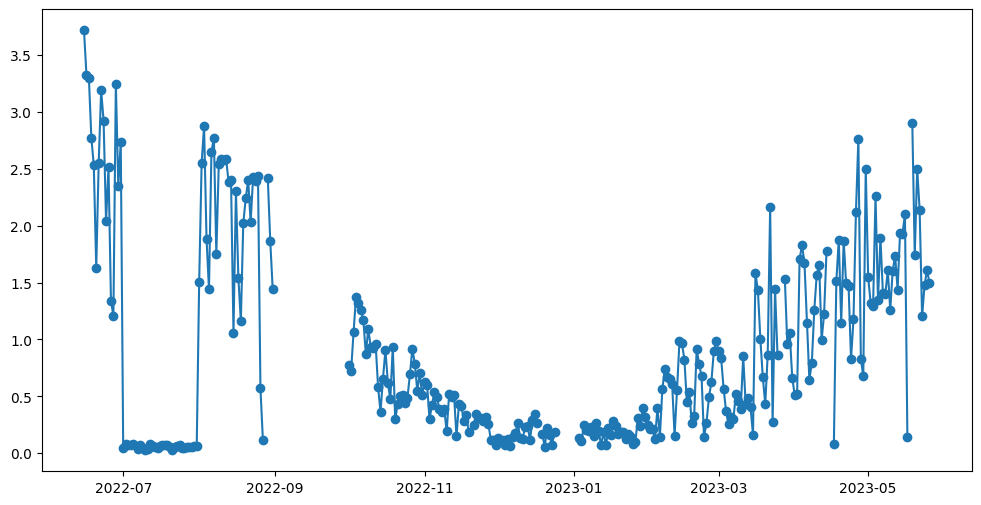

In [41]:
plot_daily_mean_data(df_UVI, df_CAMS)